# Embedding with ESM C

Hierfür wurde das [Evolutionary Scale Modeling (ESM) C](https://forge.evolutionaryscale.ai/models/esmc-300m-2024-12) Modell verwendet, welches auf der [Forge](https://forge.evolutionaryscale.ai/) Plattform gehostet wird. Dieses Notebook zeigt, wie

# Imports

In [ ]:
# Install esm and other dependencies
! pip install esm
! pip install matplotlib

# Set up Forge client for ESM C

`getpass` fragt den Token an um auf die Forge API zuzugreifen. Dies ist eine sichere Methode, um den Token nicht im Klartext im Code zu speichern.

In [2]:
from getpass import getpass
   
token = getpass("5vwVKK7xH7JDViYcieLzn4")

In [3]:
from esm.sdk import client

model = client(
    model="esmc-300m-2024-12", url="https://forge.evolutionaryscale.ai", token=token
)

# Set up utilities for embedding sequences

Da wir mehr als ein paar Sequenzen einbetten, verwenden wir einen asynchronen Thread-Aufruf auf Forge und lassen Forge die Batch-Verarbeitung und Parallelisierung im Backend übernehmen.

In [4]:
from concurrent.futures import ThreadPoolExecutor
from typing import Sequence

from esm.sdk.api import (
    ESM3InferenceClient,
    ESMProtein,
    ESMProteinError,
    LogitsConfig,
    LogitsOutput,
    ProteinType,
)

EMBEDDING_CONFIG = LogitsConfig(
    sequence=True, return_embeddings=True, return_hidden_states=True
)


def embed_sequence(model: ESM3InferenceClient, sequence: str) -> LogitsOutput:
    protein = ESMProtein(sequence=sequence)
    protein_tensor = model.encode(protein)
    output = model.logits(protein_tensor, EMBEDDING_CONFIG)
    return output


def batch_embed(
    model: ESM3InferenceClient, inputs: Sequence[ProteinType]
) -> Sequence[LogitsOutput]:
    """Forge supports auto-batching. So batch_embed() is as simple as running a collection
    of embed calls in parallel using asyncio.
    """
    with ThreadPoolExecutor() as executor:
        futures = [
            executor.submit(embed_sequence, model, protein) for protein in inputs
        ]
        results = []
        for future in futures:
            try:
                results.append(future.result())
            except Exception as e:
                results.append(ESMProteinError(500, str(e)))
    return results

# Requesting a specific hidden layer

ESM C 6B's hidden states are really large, so we only allow one specific layer to be requested per API call. This also works for other ESM C models, but it is required for ESM C 6B. 
Refer to https://forge.evolutionaryscale.ai/console to find the number of hidden layers for each model. 

In [ ]:
ESMC_6B_EMBEDDING_CONFIG = LogitsConfig(return_hidden_states=True, ith_hidden_layer=55)

# Load dataset

Wir laden unsere Aminosäure-Sequenzen aus der `gene_features.tsv` Datei. Um den Workload zu verteilen, teilen wir die Sequenzen in vier Chunks auf. Dies ist notwendig, da ESM C 6B eine große Anzahl von Parametern hat und die Verarbeitung aller Sequenzen auf einmal zu Speicherproblemen, langen Wartezeiten und unnötigen "Kollateralschäden" führen kann, wenn es während der Verarbeitung zu einem Fehler kommt.
Verschiedene Tests haben hierbei schon gezeigt, dass das "gene-g083" aufgrund seiner übermäßigen länge zu fehlern führt, wenn es in einem Chunk verarbeitet wird. Daher haben wir es aus der Liste entfernt.

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

adk_path = "../data/gene_features/gene_features.tsv"
df = pd.read_csv(adk_path, sep="\t")
print(df.columns)
df = df[["gene_id", "amino_acid_sequence", "label"]]
df = df.set_index("gene_id", drop=False)


Index(['gene_id', 'label', 'dna_sequence', 'amino_acid_sequence',
       'source_study', 'phage_name'],
      dtype='object')


In [6]:
import torch
import numpy as np
chunk_size = len(df) // 4


In [15]:
# Chunk 1
chunk1 = df[0:chunk_size]
print(f"Verarbeite Chunk 1/4 mit {len(chunk1)} Sequenzen...")

seqs1    = chunk1["amino_acid_sequence"].tolist()
ids1     = chunk1.index.tolist()  # gene_ids für diesen Chunk
outputs1 = batch_embed(model, seqs1)

# Maske für erfolgreiche Embeddings
mask1 = [not isinstance(o, ESMProteinError) for o in outputs1]

# IDs und Outputs filtern
successful_ids1     = [gid for gid, ok in zip(ids1, mask1) if ok]
successful_outputs1 = [o   for o, ok   in zip(outputs1, mask1) if ok]

# Mean-Pooling über hidden_states
emb1 = torch.stack([
    o.hidden_states.mean(dim=-2).squeeze()
    for o in successful_outputs1
]).numpy()

# Direkt als .npz speichern mit zusätzlichen Metadaten
np.savez_compressed(
    "../data/embeddings_chunk1.npz",
    embeddings=emb1,  # komplettes 3D-Array
    ids=np.array(successful_ids1),
    labels=chunk1.loc[successful_ids1, "label"].to_numpy()
)

print(f"Chunk 1: {len(successful_outputs1)}/{len(outputs1)} Embeddings erfolgreich")
print(f"Embedding-Form: {emb1.shape}")


Verarbeite Chunk 1/4 mit 312 Sequenzen...


C:\Users\decha\Desktop\Teamprojekt\venv\Lib\site-packages\esm\utils\misc.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


ValueError: Must pass 2-d input. shape=(311, 31, 960)

In [16]:
# Direkt als .npz speichern mit zusätzlichen Metadaten
np.savez_compressed(
    "../data/embeddings_chunk1.npz",
    embeddings=emb1,  # komplettes 3D-Array
    ids=np.array(successful_ids1),
    labels=chunk1.loc[successful_ids1, "label"].to_numpy()
)

print(f"Chunk 1: {len(successful_outputs1)}/{len(outputs1)} Embeddings erfolgreich")
print(f"Embedding-Form: {emb1.shape}")

Chunk 1: 311/312 Embeddings erfolgreich
Embedding-Form: (311, 31, 960)


In [19]:
# Lade die .npz Datei mit allow_pickle=True
data = np.load('../data/embeddings_chunk1.npz', allow_pickle=True)

# Zeige die verfügbaren Arrays in der Datei
print("Verfügbare Arrays:", data.files)

# Inspiziere die Dimensionen
print("\nDimensionen:")
for key in data.files:
    print(f"{key}: {data[key].shape}")

# Zeige die ersten Einträge der Labels und IDs
print("\nErste Labels:", data['labels'][:5])
print("\nErste IDs:", data['ids'][:5])

Verfügbare Arrays: ['embeddings', 'ids', 'labels']

Dimensionen:
embeddings: (311, 31, 960)
ids: (311,)
labels: (311,)

Erste Labels: ['early' 'late' 'late' 'late' 'middle']

Erste IDs: ['gene-PPLUZ19_gp23' 'gene-PPLUZ19_gp36' 'gene-PPLUZ19_gp16'
 'gene-PPLUZ19_gp40' 'gene-PPLUZ19_gp44']


In [20]:
# Chunk 2
chunk2 = df[chunk_size:chunk_size*2]
print(f"Verarbeite Chunk 2/4 mit {len(chunk2)} Sequenzen...")

seqs2    = chunk2["amino_acid_sequence"].tolist()
ids2     = chunk2.index.tolist()  # gene_ids für diesen Chunk
outputs2 = batch_embed(model, seqs2)

# Maske für erfolgreiche Embeddings
mask2 = [not isinstance(o, ESMProteinError) for o in outputs2]

# IDs und Outputs filtern
successful_ids2     = [gid for gid, ok in zip(ids2, mask2) if ok]
successful_outputs2 = [o   for o, ok   in zip(outputs2, mask2) if ok]

# Mean-Pooling über hidden_states
emb2 = torch.stack([
    o.hidden_states.mean(dim=-2).squeeze()
    for o in successful_outputs2
]).numpy()

# Direkt als .npz speichern mit zusätzlichen Metadaten
np.savez_compressed(
    "../data/embeddings_chunk2.npz",
    embeddings=emb2,  # komplettes 3D-Array
    ids=np.array(successful_ids2),
    labels=chunk2.loc[successful_ids2, "label"].to_numpy()
)

print(f"Chunk 2: {len(successful_outputs2)}/{len(outputs2)} Embeddings erfolgreich")
print(f"Embedding-Form: {emb2.shape}")

Verarbeite Chunk 2/4 mit 312 Sequenzen...


C:\Users\decha\Desktop\Teamprojekt\venv\Lib\site-packages\esm\utils\misc.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


Chunk 2: 312/312 Embeddings erfolgreich
Embedding-Form: (312, 31, 960)


In [21]:
# Chunk 3
chunk3 = df[chunk_size*2:chunk_size*3]
print(f"Verarbeite Chunk 3/4 mit {len(chunk3)} Sequenzen...")

seqs3    = chunk3["amino_acid_sequence"].tolist()
ids3     = chunk3.index.tolist()  # gene_ids für diesen Chunk
outputs3 = batch_embed(model, seqs3)

# Maske für erfolgreiche Embeddings
mask3 = [not isinstance(o, ESMProteinError) for o in outputs3]

# IDs und Outputs filtern
successful_ids3     = [gid for gid, ok in zip(ids3, mask3) if ok]
successful_outputs3 = [o   for o, ok   in zip(outputs3, mask3) if ok]

# Hidden states ohne Mittelung speichern
emb3 = torch.stack([
    o.hidden_states.mean(dim=-2).squeeze()
    for o in successful_outputs3
]).numpy()

# Direkt als .npz speichern mit zusätzlichen Metadaten
np.savez_compressed(
    "../data/embeddings_chunk3.npz",
    embeddings=emb3,
    ids=np.array(successful_ids3),
    labels=chunk3.loc[successful_ids3, "label"].to_numpy()
)

print(f"Chunk 3: {len(successful_outputs3)}/{len(outputs3)} Embeddings erfolgreich")
print(f"Embedding-Form: {emb3.shape}")

Verarbeite Chunk 3/4 mit 312 Sequenzen...


C:\Users\decha\Desktop\Teamprojekt\venv\Lib\site-packages\esm\utils\misc.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


Chunk 3: 312/312 Embeddings erfolgreich
Embedding-Form: (312, 31, 960)


In [7]:
# Chunk 4
chunk4 = df[chunk_size*3:]
print(f"Verarbeite Chunk 4/4 mit {len(chunk4)} Sequenzen...")

seqs4    = chunk4["amino_acid_sequence"].tolist()
ids4     = chunk4.index.tolist()  # gene_ids für diesen Chunk
outputs4 = batch_embed(model, seqs4)

# Maske für erfolgreiche Embeddings
mask4 = [not isinstance(o, ESMProteinError) for o in outputs4]

# IDs und Outputs filtern
successful_ids4     = [gid for gid, ok in zip(ids4, mask4) if ok]
successful_outputs4 = [o   for o, ok   in zip(outputs4, mask4) if ok]

# Mean-Pooling über hidden_states
emb4 = torch.stack([
    o.hidden_states.mean(dim=-2).squeeze()
    for o in successful_outputs4
]).numpy()

# Direkt als .npz speichern mit zusätzlichen Metadaten
np.savez_compressed(
    "../data/embeddings_chunk4.npz",
    embeddings=emb4,
    ids=np.array(successful_ids4),
    labels=chunk4.loc[successful_ids4, "label"].to_numpy()
)

print(f"Chunk 4: {len(successful_outputs4)}/{len(outputs4)} Embeddings erfolgreich")
print(f"Embedding-Form: {emb4.shape}")

Verarbeite Chunk 4/4 mit 315 Sequenzen...


C:\Users\decha\Desktop\Teamprojekt\venv\Lib\site-packages\esm\utils\misc.py:273: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x)


Chunk 4: 315/315 Embeddings erfolgreich
Embedding-Form: (315, 31, 960)


In [9]:
# Zusammenfügen aller Chunks
final_embeddings = np.concatenate([
    np.load('../data/embeddings_chunk1.npz', allow_pickle=True)['embeddings'],
    np.load('../data/embeddings_chunk2.npz', allow_pickle=True)['embeddings'],
    np.load('../data/embeddings_chunk3.npz', allow_pickle=True)['embeddings'],
    np.load('../data/embeddings_chunk4.npz', allow_pickle=True)['embeddings']
])

# Zusammenfügen der IDs und Labels
final_ids = np.concatenate([
    np.load('../data/embeddings_chunk1.npz', allow_pickle=True)['ids'],
    np.load('../data/embeddings_chunk2.npz', allow_pickle=True)['ids'],
    np.load('../data/embeddings_chunk3.npz', allow_pickle=True)['ids'],
    np.load('../data/embeddings_chunk4.npz', allow_pickle=True)['labels']
])

final_labels = np.concatenate([
    np.load('../data/embeddings_chunk1.npz', allow_pickle=True)['labels'],
    np.load('../data/embeddings_chunk2.npz', allow_pickle=True)['labels'],
    np.load('../data/embeddings_chunk3.npz', allow_pickle=True)['labels'],
    np.load('../data/embeddings_chunk4.npz', allow_pickle=True)['labels']
])

# Speichere das komplette Array mit Metadaten
np.savez_compressed(
    '../data/embeddings_complete.npz',
    embeddings=final_embeddings,
    ids=final_ids,
    labels=final_labels
)

print("Form des finalen Arrays:", final_embeddings.shape)

# Überprüfen der gespeicherten Daten
data = np.load('../data/embeddings_complete.npz', allow_pickle=True)
print("\nVerfügbare Arrays:", data.files)
print("Dimensionen der Embeddings:", data['embeddings'].shape)

Form des finalen Arrays: (1250, 31, 960)

Verfügbare Arrays: ['embeddings', 'ids', 'labels']
Dimensionen der Embeddings: (1250, 31, 960)


In [10]:
import numpy as np

# Lade die .npz Datei
data = np.load('../data/embeddings_complete.npz', allow_pickle=True)

# Hole die Embeddings aus der .npz Datei
embeddings = data['embeddings']

# Zeige die Form des Arrays
print("Shape:", embeddings.shape)

# Zeige die ersten Einträge
print("\nErste Einträge:")
print(embeddings[0])

# Zeige auch die verfügbaren Arrays
print("\nVerfügbare Arrays in der Datei:", data.files)

Shape: (1250, 31, 960)

Erste Einträge:
[[ 1.72798201e-01  1.38347492e-01 -2.61815786e-01 ... -6.14622310e-02
   9.49157998e-02 -1.78026617e-01]
 [-2.47076124e-01 -1.69921130e-01 -2.54160553e-01 ... -1.16262682e-01
   5.90084493e-02 -2.16668993e-01]
 [-1.68515787e-01 -4.71317098e-02 -1.50716454e-01 ... -3.83404531e-02
   4.22625877e-02 -3.30321521e-01]
 ...
 [ 1.24771631e+00  1.31135809e+00  4.23850250e+00 ... -2.26427531e+00
   1.46919603e+01  3.65664458e+00]
 [ 6.29476261e+00  1.37668095e+01  1.28140521e+00 ...  4.16580153e+00
  -1.34646773e+00  9.76852417e-01]
 [ 4.29918664e-03 -6.79373392e-04  4.44366410e-03 ...  1.06027788e-02
  -5.01962984e-03 -1.23620285e-02]]

Verfügbare Arrays in der Datei: ['embeddings', 'ids', 'labels']


# Examine the performance of different layer embeddings

For this example, we're going to use PCA to visualize whether the embeddings separate our proteins by their structural class. To assess the quality of our PCA, we fit a K means classifier with three clusters, corresponding to the three structural classes of our enzyme, and compute the [rand index](https://en.wikipedia.org/wiki/Rand_index), a measure of the quality of the clustering.

In [11]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score

N_KMEANS_CLUSTERS = 3

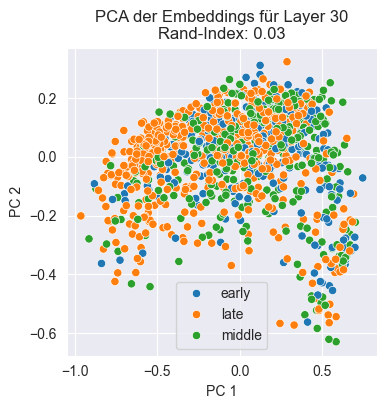

In [12]:
def plot_embeddings_at_layer(embeddings: np.ndarray, layer_idx: int, labels: np.ndarray):
    layer_embeddings = embeddings[:, layer_idx, :]
    
    # PCA auf 2D reduzieren
    pca = PCA(n_components=2)
    pca.fit(layer_embeddings)
    projected_embeddings = pca.transform(layer_embeddings)
    
    # K-Means Clustering durchführen
    kmeans = KMeans(n_clusters=N_KMEANS_CLUSTERS, random_state=0).fit(
        projected_embeddings
    )
    rand_index = adjusted_rand_score(labels, kmeans.labels_)
    
    # Cluster visualisieren
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=projected_embeddings[:, 0],
        y=projected_embeddings[:, 1],
        hue=labels,
    )
    plt.title(
        f"PCA der Embeddings für Layer {layer_idx}\nRand-Index: {rand_index:.2f}"
    )
    plt.xlabel("PC 1")
    plt.ylabel("PC 2")
    plt.show()



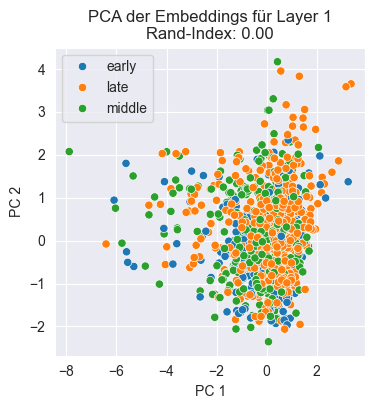

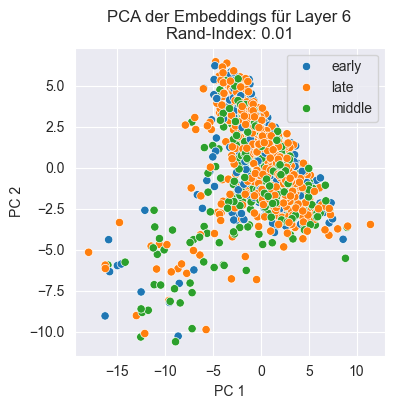

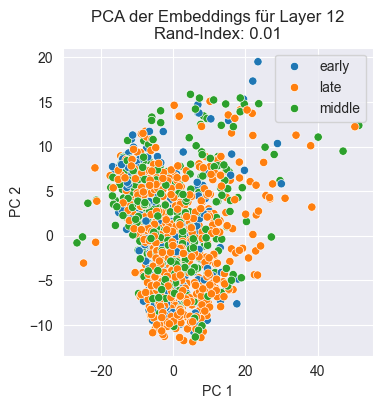

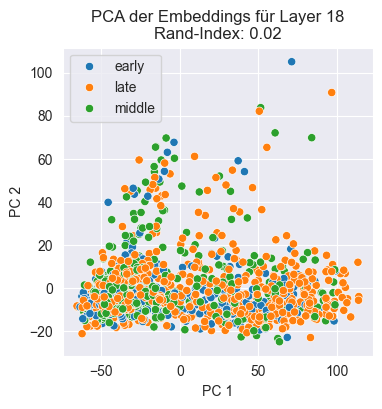

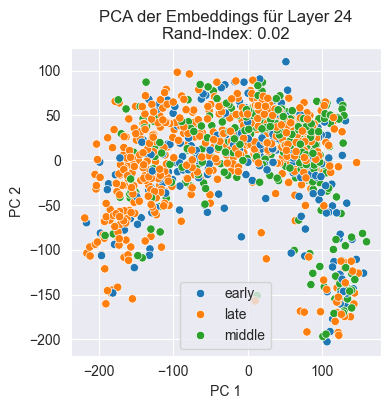

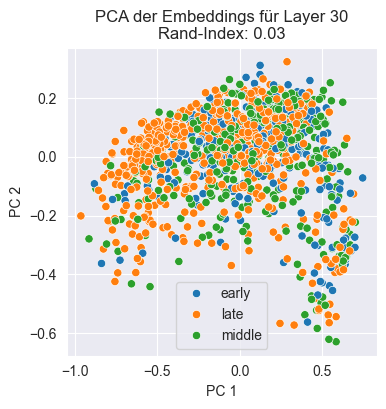

IndexError: index 31 is out of bounds for axis 1 with size 31

In [17]:
# Daten laden
data = np.load('../data/embeddings_complete.npz', allow_pickle=True)

# Test verschiedener Layer
test_layers = [1, 6, 12, 18, 24, 30, 31]

for layer in test_layers:
    plot_embeddings_at_layer(
        embeddings=data['embeddings'],
        layer_idx=layer,
        labels=data['labels']
    )

We see that the top principal components of layer 12 separate structural classes better than that of layer 30. Embed away! And keep in mind that different layers may be better or worse for your particular use-case.

In [19]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.manifold import TSNE
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_tsne_at_layer(embeddings: np.ndarray, layer_idx: int, labels: np.ndarray, perplexity=30):
    layer_embeddings = embeddings[:, layer_idx, :]

    # t-SNE Reduktion
    tsne = TSNE(
        n_components=2,
        perplexity=perplexity,
        random_state=42,
        n_iter=1000
    )
    projected_embeddings = tsne.fit_transform(layer_embeddings)

    # K-Means Clustering
    kmeans = KMeans(n_clusters=N_KMEANS_CLUSTERS, random_state=0).fit(projected_embeddings)
    
    # Verschiedene Metriken berechnen
    ari = adjusted_rand_score(labels, kmeans.labels_)
    silhouette = silhouette_score(projected_embeddings, labels)
    calinski = calinski_harabasz_score(projected_embeddings, labels)

    # Visualisierung
    plt.figure(figsize=(6, 6))
    sns.scatterplot(
        x=projected_embeddings[:, 0],
        y=projected_embeddings[:, 1],
        hue=labels,
    )
    plt.title(
        f"t-SNE der Embeddings für Layer {layer_idx}\n"
        f"ARI: {ari:.2f}, Silhouette: {silhouette:.2f}\n"
        f"Calinski-Harabasz: {calinski:.0f}"
    )
    plt.xlabel("t-SNE 1")
    plt.ylabel("t-SNE 2")
    plt.show()

C:\Users\decha\Desktop\Teamprojekt\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


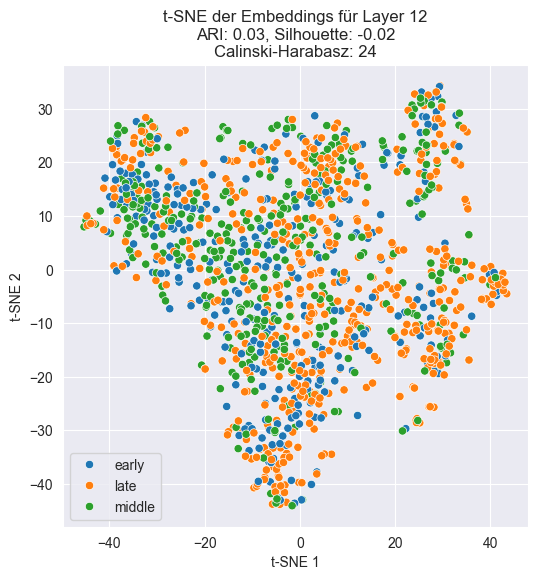

C:\Users\decha\Desktop\Teamprojekt\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


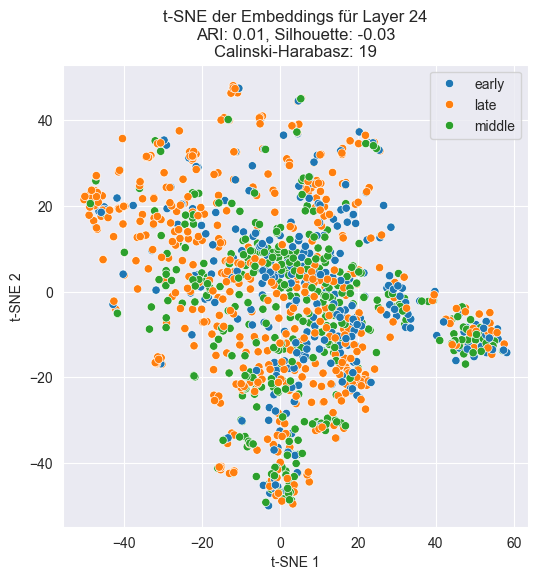

C:\Users\decha\Desktop\Teamprojekt\venv\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


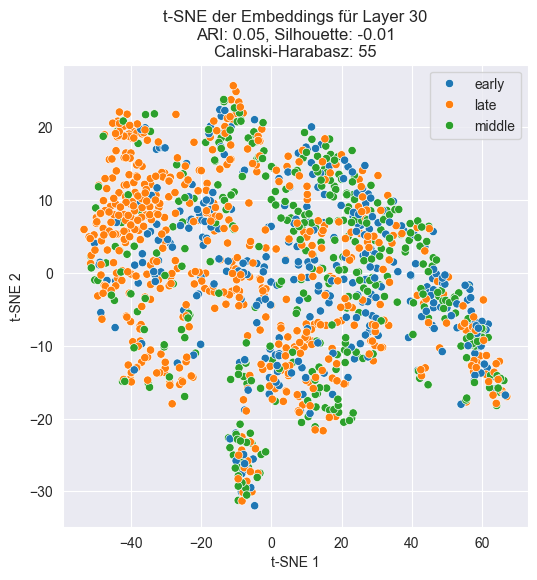

In [20]:
# Test verschiedener Layer
test_layers = [12, 24, 30]  # Layer mit guten Ergebnissen aus PCA
for layer in test_layers:
    plot_tsne_at_layer(
        embeddings=data['embeddings'],
        layer_idx=layer,
        labels=data['labels']
    )